In [1]:
# ⓞ
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# ④ CIFAR-10 dataset
from keras.datasets import cifar10
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 3s 0us/step


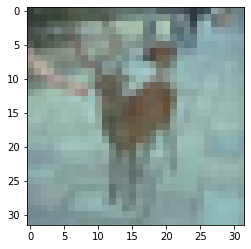

In [3]:
plt.imshow(X_train[153])

In [4]:
# ⑤ Preprocessing
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0

In [5]:
# ⑥ Validation Set 만들기
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, \
                                                  test_size = 0.2, shuffle = True)

In [6]:
# ⑦ Y : 0~9의 값 "하나" -> OneHot vector로 만들어주기
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
encoder.fit(Y_train)
Y_train = encoder.transform(Y_train).toarray()
Y_test = encoder.transform(Y_test).toarray()
Y_val =  encoder.transform(Y_val).toarray()

In [7]:
# ① MobileNet block 구현
class MobileNet_Block(tf.keras.Model):
  def __init__(self, filters, strides):
    super(MobileNet_Block, self).__init__(name='')

    self.conv_dw = tf.keras.layers.DepthwiseConv2D(kernel_size = (3, 3), strides = strides, padding = 'same')
    self.bn1 = tf.keras.layers.BatchNormalization()
    self.act1 = tf.keras.layers.Activation('relu')

    self.conv = tf.keras.layers.Conv2D(filters = filters, kernel_size = (1, 1), strides = 1, padding = 'same')
    self.bn2 = tf.keras.layers.BatchNormalization()
    self.act2 = tf.keras.layers.Activation('relu')

    '''
    self.downsample = downsample
    if self.downsample:
      self.ds = tf.keras.layers.Conv2D(filters, strides=2, kernel_size=(1,1), padding='same')
      self.dsbn = tf.keras.layers.BatchNormalization()
    '''

  def call(self, inputs):
    '''
    ds = inputs
    if self.downsample: # 만약 downsample이면
      ds = self.ds(inputs)  # downsampling layer를 거친다
      ds = self.dsbn(ds)
    '''

    x = self.conv_dw(inputs)
    x = self.bn1(x)
    x = self.act1(x)

    x = self.conv(x)
    x = self.bn2(x)
    out = self.act2(x)

    return out

In [8]:
class MobileNet(tf.keras.Model):
  def __init__(self, num_classes):
    super(MobileNet, self).__init__()

    # stem layer
    self.conv1 = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), strides = 2, padding='same')
    self.bn1 = tf.keras.layers.BatchNormalization()
    self.act1 = tf.keras.layers.Activation('relu')

    # main layers
    self.conv2 = MobileNet_Block(filters = 64, strides = 1)
    self.conv3 = MobileNet_Block(filters = 128, strides = 2)
    self.conv4 = MobileNet_Block(filters = 128, strides = 1)
    self.conv5 = MobileNet_Block(filters = 256, strides = 2)
    self.conv6 = MobileNet_Block(filters = 256, strides = 1)

    #self.avg_pool = tf.keras.layers.AvgPool2D(pool_size=(4, 4), strides=1, data_format='channels_first')
    self.avg_pool = tf.keras.layers.GlobalAveragePooling2D()
    self.flat = tf.keras.layers.Flatten()
    self.fc = tf.keras.layers.Dense(units=num_classes, activation='softmax')

  def call(self, inputs):
    x = self.conv1(inputs)
    x = self.bn1(x) # 실습 강의에서는 bn은 생략함
    x = self.act1(x)
    
    for mbblock in [self.conv2, self.conv3, self.conv4, self.conv5, self.conv6]:
      x = mbblock(x)

    x = self.avg_pool(x)
    x = self.flat(x)
    out = self.fc(x)

    return out

In [9]:
# ③ 모델 컴파일

model = MobileNet(10)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
# ⑨ fit
history = model.fit(X_train, Y_train, batch_size = 256, epochs = 10, validation_data = (X_val, Y_val))

Epoch 1/10
157/157 [==============================] - 21s 43ms/step - loss: 1.5982 - accuracy: 0.4143 - val_loss: 2.6353 - val_accuracy: 0.1003
Epoch 2/10
157/157 [==============================] - 6s 38ms/step - loss: 1.2373 - accuracy: 0.5544 - val_loss: 3.2079 - val_accuracy: 0.1041
Epoch 3/10
157/157 [==============================] - 6s 39ms/step - loss: 1.0692 - accuracy: 0.6177 - val_loss: 2.8752 - val_accuracy: 0.1399
Epoch 4/10
157/157 [==============================] - 6s 40ms/step - loss: 0.9517 - accuracy: 0.6610 - val_loss: 1.3834 - val_accuracy: 0.5001
Epoch 5/10
157/157 [==============================] - 6s 40ms/step - loss: 0.8594 - accuracy: 0.6940 - val_loss: 1.2759 - val_accuracy: 0.5653
Epoch 6/10
157/157 [==============================] - 6s 38ms/step - loss: 0.7823 - accuracy: 0.7251 - val_loss: 1.1915 - val_accuracy: 0.5928
Epoch 7/10
157/157 [==============================] - 6s 38ms/step - loss: 0.7059 - accuracy: 0.7521 - val_loss: 1.1561 - val_accuracy: 0.612

In [11]:
# ⑩ test해주기
model.evaluate(X_test, Y_test)

313/313 [==============================] - 2s 7ms/step - loss: 1.2692 - accuracy: 0.6166


[1.2692124843597412, 0.616599977016449]

In [12]:
# ⑪ 모델 summary
model.summary()

Model: "mobile_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  896       
                                                                 
 batch_normalization (BatchN  multiple                 128       
 ormalization)                                                   
                                                                 
 activation (Activation)     multiple                  0         
                                                                 
  (MobileNet_Block)          multiple                  2816      
                                                                 
  (MobileNet_Block)          multiple                  9728      
                                                                 
  (MobileNet_Block)          multiple                  18816     
                                                        

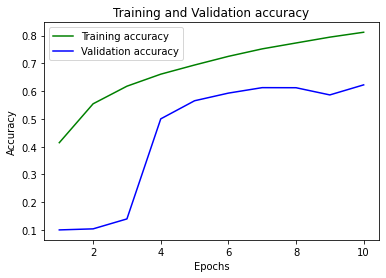

In [14]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,11)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()